# Oil Palm Plantations Detection: Towards Demystifying Deforestation Impact 

## Overview:

This notebook presents a binary image classification work using satellite images to detect oil palm plantations. In recent years, the growth in oil palm plantations has become the new agricultural trend that has largely contributed towards both environmental i.e. deforestation and biodiversity loss, and economical i.e. job opportunities, impacts. Further study towards this newly developed trend is highly crucial in order to understand and address the global impact.

The advancement in computer vision and the availability of high resolution satellite imagery systems have provided a promising opportunity to auto map oil palm plantations for further analysis. The training image dataset employed in this work consists of 15244 satellite images, each with a 3 meter spatial resolution. (https://www.kaggle.com/c/widsdatathon2019/dat)

Transfer learning or fine tuning approach on existing pre-trained deep learning approach is employed in this work, in particular the VGG19 network. This work is performed using Keras libraries with Tensorflow backend and a few other Python machine learning libraries.

In [1]:
# Loading the libraries

import pandas as pd
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.applications import VGG19
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras import optimizers 
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import keras_metrics


Using TensorFlow backend.


## Training and testing dataset preparation

-  The 'training_labels' file provides the image id of all training images together with the class label.
-  The training image dataset need to be split into two folders i.e. 0 (no oil palm images) and 1 ( oil palm images).

In [2]:
file=pd.read_csv('traininglabels.csv')
lists = os.listdir('train_images\\train_images\\')  # list of all training images

In [3]:
print(file.shape)
file.head()

(15244, 3)


image_id  has_oilpalm   score
0  img_000002017.jpg            0  0.7895
1  img_000012017.jpg            0  1.0000
2  img_000022017.jpg            0  1.0000
3  img_000072017.jpg            0  1.0000
4  img_000082017.jpg            0  1.0000

-  The dataframe has 15244 rows with 3 columns.
-  The second column is a class indicator column and will be used to split the dataset into two class folders.

In [5]:
# Spliting the images for the two classses i.e.with and without the oil palm

num_files=len(lists)

for i in range (0,num_files):
        source = 'train_images\\train_images\\'+file['image_id'].iloc[i]
        if file['has_oilpalm'].iloc[i] == 0:
            shutil.copy(source,'training_set\\Class0\\'+ file['image_id'].iloc[i] )
        else:
            shutil.copy(source,'training_set\\Class1\\'+ file['image_id'].iloc[i] )
        

After spliting the images into two classes, the images then need to be grouped into training and testing set using random sampling.

In [6]:
list1 = os.listdir('training_set\\Class1\\') 

r1=random.sample(range(len(list1)), 150) # about 15% of class1 images is set aside for testing 

for i in r1:
        source = 'training_set\\Class1\\'+list1[i]
        shutil.move(source,'test_set\Class1\\'+list1[i] )
       


In [7]:
list0 = os.listdir('training_set\\Class0\\') # dir is your directory path

r0=random.sample(range(len(list0)), 2300)  # about 15% of class0 images is set aside for testing

for i in r0:
        source = 'training_set\\Class0\\'+list0[i]
        shutil.move(source,'test_set\Class0\\'+list0[i] )
       


The following codes are for:
-  image augmentation for the training data and image rescaling for both training and test data
-  setting up training and testing data flow for weight computations in the deep learning network

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
                               

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary')


Found 12794 images belonging to 2 classes.
Found 2450 images belonging to 2 classes.


Let's see some images from the two classes

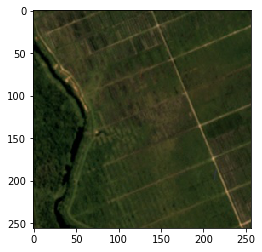

In [10]:
# An image with oil palm plantation

plt.imshow(mpimg.imread('test_set\\Class1\\'+os.listdir('test_set\\Class1\\') [1]))

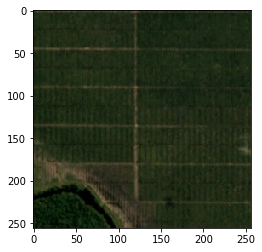

In [11]:
# Another image with oil palm plantation

plt.imshow(mpimg.imread('test_set\\Class1\\'+os.listdir('test_set\\Class1\\') [10]))

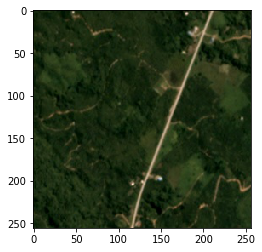

In [12]:
# An image without oil palm plantation

plt.imshow(mpimg.imread('test_set\\Class0\\'+os.listdir('test_set\\Class0\\') [7]))

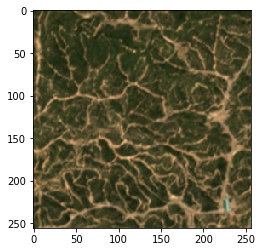

In [13]:
# Another image without oil palm plantation

plt.imshow(mpimg.imread('test_set\\Class0\\'+os.listdir('test_set\\Class0\\') [70]))

## Setting up the pre-trained network for fine tuning

This part of the work consists of two main stages:

1.  The first part is to train the network by first freezing the weights in the convolutional layers and tune the weights in the fully connected layers. VGG19 network is first initialized and the weights from imagenet dataset is loaded into the network. The convolutions layers in VGG19 network will be set to 'False' as we want to freeze the weights in these layers. Next, fully connected layers that acts as the classifier is defined and connected to the convolutional layers output of the network. The network is then trained and the weights from this phase is then further employed in the next training phase.

2. In the second stage, VGG19 network is still employed but this time, the convolutional layers is not freezed, allowing the weights in this layers to be tuned together with weights in the fully connected layers. The network is then retrained and the weights from this training is the ones that defined the final model and used for future classification/prediction.



In [14]:
# Base network initialization

base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128,128,3)) 

i=0
for layer in base_model.layers:
    layer.trainable = False   # freeze the convolution layers
    i = i+1
    print(i,layer.name)

1 input_1
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_conv4
12 block3_pool
13 block4_conv1
14 block4_conv2
15 block4_conv3
16 block4_conv4
17 block4_pool
18 block5_conv1
19 block5_conv2
20 block5_conv3
21 block5_conv4
22 block5_pool


In [15]:
# The fully connected network creation

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

predictions = Dense(units=1, activation='sigmoid')(x)

Model initialization, compilation and fitting. The optimizer used here is Adam optimizer for faster convergence.

In [16]:
filepath = 'model\\VGG19.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='auto',period=1)
callbacks_list = [checkpoint]

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
model.fit_generator(training_set,
                         steps_per_epoch = 400,
                         epochs = 25,
                         validation_data = test_set,
                         validation_steps = 100,                         
                         callbacks = callbacks_list)

Epoch 1/25
400/400 [==============================] - 113s 282ms/step - loss: 0.2765 - acc: 0.8980 - precision: 0.3450 - recall: 0.7210 - f1_score: 0.4667 - val_loss: 0.1598 - val_acc: 0.9620 - val_precision: 0.6310 - val_recall: 0.8906 - val_f1_score: 0.7387

Epoch 00001: val_loss improved from inf to 0.15985, saving model to model\VGG19.h5
Epoch 2/25
400/400 [==============================] - 110s 274ms/step - loss: 0.1034 - acc: 0.9702 - precision: 0.8081 - recall: 0.6806 - f1_score: 0.7389 - val_loss: 0.0726 - val_acc: 0.9837 - val_precision: 0.9106 - val_recall: 0.8191 - val_f1_score: 0.8624

Epoch 00002: val_loss improved from 0.15985 to 0.07265, saving model to model\VGG19.h5
Epoch 3/25
400/400 [==============================] - 110s 274ms/step - loss: 0.0914 - acc: 0.9728 - precision: 0.8415 - recall: 0.6907 - f1_score: 0.7587 - val_loss: 0.1134 - val_acc: 0.9708 - val_precision: 0.7095 - val_recall: 0.8814 - val_f1_score: 0.7862

Epoch 00003: val_loss did not improve from 0.07

The following is the second stage of the training phase in which the convolutional layers are not freezed, allowing the weights in these layers to be tuned based on image dataset used.

In [17]:
base_model_finetune = VGG19(include_top=False, weights=None,input_shape=(128,128,3))

for layer in base_model_finetune.layers:
    layer.trainable = True
    
x = base_model_finetune.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

predictions = Dense(units=1,activation = 'sigmoid')(x)

Final model initialization, compilation and fitting. Here, stochastic gradient descent optimizer is used at 0.0001 learning rate.

In [18]:
# Final model initialization, compilation and fitting.

filepath = 'model\\fine_tune_VGG19.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='auto',period=1)
callbacks_list = [checkpoint]

model_finetune = Model(inputs=base_model_finetune.input, outputs=predictions)
model_finetune.load_weights("model\\VGG19.h5")
model_finetune.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
model_finetune.fit_generator(training_set,
                         steps_per_epoch = 400,
                         epochs = 50,
                         validation_data = test_set,
                         validation_steps = 100,
                         callbacks = callbacks_list)


Epoch 1/50
400/400 [==============================] - 327s 816ms/step - loss: 0.0520 - acc: 0.9834 - precision: 0.9026 - recall: 0.8194 - f1_score: 0.8590 - val_loss: 0.0380 - val_acc: 0.9893 - val_precision: 0.9444 - val_recall: 0.8763 - val_f1_score: 0.9091

Epoch 00001: val_loss improved from inf to 0.03796, saving model to model\fine_tune_VGG19.h5
Epoch 2/50
400/400 [==============================] - 325s 811ms/step - loss: 0.0432 - acc: 0.9865 - precision: 0.9154 - recall: 0.8611 - f1_score: 0.8874 - val_loss: 0.0421 - val_acc: 0.9896 - val_precision: 0.9750 - val_recall: 0.8432 - val_f1_score: 0.9043

Epoch 00002: val_loss did not improve from 0.03796
Epoch 3/50
400/400 [==============================] - 325s 812ms/step - loss: 0.0408 - acc: 0.9872 - precision: 0.9313 - recall: 0.8561 - f1_score: 0.8921 - val_loss: 0.0668 - val_acc: 0.9787 - val_precision: 0.7747 - val_recall: 0.9469 - val_f1_score: 0.8522

Epoch 00003: val_loss did not improve from 0.03796
Epoch 4/50
400/400 [==

400/400 [==============================] - 324s 810ms/step - loss: 0.0148 - acc: 0.9954 - precision: 0.9754 - recall: 0.9495 - f1_score: 0.9623 - val_loss: 0.0210 - val_acc: 0.9947 - val_precision: 0.9709 - val_recall: 0.9330 - val_f1_score: 0.9516

Epoch 00026: val_loss did not improve from 0.01752
Epoch 27/50
400/400 [==============================] - 324s 810ms/step - loss: 0.0140 - acc: 0.9958 - precision: 0.9805 - recall: 0.9508 - f1_score: 0.9654 - val_loss: 0.0236 - val_acc: 0.9946 - val_precision: 0.9737 - val_recall: 0.9391 - val_f1_score: 0.9561

Epoch 00027: val_loss did not improve from 0.01752
Epoch 28/50
400/400 [==============================] - 324s 810ms/step - loss: 0.0136 - acc: 0.9958 - precision: 0.9743 - recall: 0.9571 - f1_score: 0.9656 - val_loss: 0.0247 - val_acc: 0.9947 - val_precision: 0.9833 - val_recall: 0.9267 - val_f1_score: 0.9542

Epoch 00028: val_loss did not improve from 0.01752
Epoch 29/50
400/400 [==============================] - 324s 810ms/step - 

## Image prediction

Let's see model predictions for the images shown at the beginning of this notebook

In [19]:
# Prediction for an image from the class with oil palm plantation images

image = load_img('test_set\\Class1\\'+os.listdir('test_set\\Class1\\') [1], target_size=(128,128))
image = img_to_array(image)  
image = np.expand_dims(image, axis=0)  
image = image/255.0
print(float(model_finetune.predict(image)))

0.9995386600494385


In [20]:
# Prediction for an image from the class with oil palm plantation images

image = load_img('test_set\\Class1\\'+os.listdir('test_set\\Class1\\') [10], target_size=(128,128))
image = img_to_array(image)  
image = np.expand_dims(image, axis=0)  
image = image/255.0
print(float(model_finetune.predict(image)))

0.9997637867927551


In [21]:
# Prediction for an image from the class without oil palm plantation images

image = load_img('test_set\\Class0\\'+os.listdir('test_set\\Class0\\') [7], target_size=(128,128))
image = img_to_array(image)  
image = np.expand_dims(image, axis=0)  
image = image/255.0
print(float(model_finetune.predict(image)))

0.00032454042229801416


In [22]:
# Prediction for an image from the class without oil palm plantation images

image = load_img('test_set\\Class0\\'+os.listdir('test_set\\Class0\\') [70], target_size=(128,128))
image = img_to_array(image)  
image = np.expand_dims(image, axis=0)  
image = image/255.0
print(float(model_finetune.predict(image)))

0.0004567970463540405


Looks like the model provides good predictions for both classes.

## Conclusions

-  This notebook provides a fine tuning mechanism when using pre-trained network for binary image classification.
-  A pre-trained model is used i.e. VGG19 network and the weights is initialized using the weights trained on imagenet database.
-  To obtain the final model tailored to the dataset used in this work, the network is trained twice.
-  In the first training, the convolutional layers of VGG19 is freezed (forcing the network to use the weights trained on imagenet database).
-  In the second training, the network is initialized with the weights obtained from the first training and further fine tuned using stochastic gradient descent optimizer.